# DesiSequencer
This notebook is an interactive script to read DESI data from oligourethane sequencing experiments and assinging a sequence to the mass spectra. Before continuing, you must convert the .RAW files from the instrument into plaintext files that Python can read. This is further explained in the README.md file of the repository. After that, run the `Imports` cell and modify your settings in the `Constants and Settings` cell if needed. Then run the remaining cells interactively.

## Imports

In [1]:
# Built ins
from pathlib import Path

# Data processing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Custom
from utils import read_desi_data_file, get_average_intensity_of_scan, get_spots, combine_scans, mass_to_monomer
from utils import identify_masses_from_sequencing, find_parent_mass


## Constants and Settings
This should be the __only__ cell you modify. Here you will find definitions for the endcaps, monomer masses, and several settings that affect the sequencing procedure.

In [2]:
# Specify a file for sequencing
file = Path('./julia_data/04172024_oligomers_CVprofiling_A-F_3rdtry.txt')
#file = Path('./julia_data/04172024_oligomers_CVprofiling_A-F_2ndtry.txt')

# Define endcap information
endcap_mass = 262.084
endcap_name = 'Tyr(OMe)'

# Define the monomer masses
monomer_masses = {
    101.0477:'Ala',
    103.0602:'D2Ala',
    115.0633:'Abu',
    117.0759:'D2Abu',
    127.0633:'Gly(allyl)',
    129.0759:'D2Allyl',
    131.0582:'Ser',
    133.0708:'D2Ser',
    143.0946:'Leu',
    145.1072:'D2Leu',
    177.0790:'Phe',
    179.0915:'D2Phe',
    183.1259:'Cha',
    185.1385:'D2Cha',
    191.0949:'HoPhe',
    193.0739:'Tyr(OH)',
    193.1072:'D2HoPhe',
    195.0864:'D2Tyr(OH)',
    207.0895:'TyrOMe',
    209.1021:'D2TyrOMe',
}

# This is the scan intensity threshold that is used to evaluate
# whether a scan (effectively time point for DESI) is considered
# a "spot" or "peak" in the sequncing experiment. Set to 'auto' 
# unless you have a good reason not to!
scan_intensity_threshold = 'auto'

# spot_width controls the smoothing of the intensity scans
spot_width = 6

# Threshold in absolute intensity units (counts)
# above which signals contribute to the total intensity
# of a scan. This is useful for spectra with many low intensity signals
mass_thresh = 500

# Rounding for the reading/cleaning up of scans
mz_round = 3

# Turn on or off misc debug printing
debug = False

# This is an unused value for controlling the 
# threshold (in % of tallest peak) of the ion count
# above which MS signals are considered for monomer assignment
intensity_threshold = 0.20

# Minimum % of tallest peak above which signals
# are considered for parent peak selection
parent_peak_threshold = 0.04

# Tolerance in % of endcap mass within which
# m/z values are considered for endcap assignment
endcap_tolerance = 0.1

# Directory for storing figures
fig_dir = Path('./figures/')

## Read in and process the data

[INFO] Automatically setting threshold to 34780.74380267702 counts
[INFO] Found 6 extrema in the spot scan. This means there are six peaks/samples.


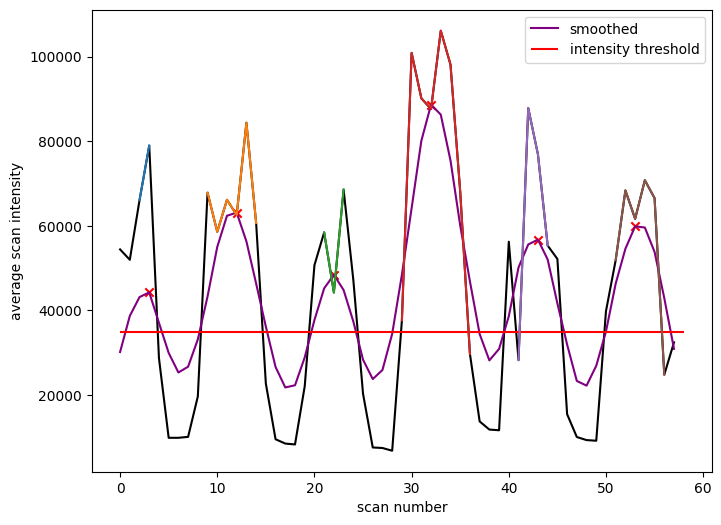

In [3]:
# Get a list of scans in the file
scans = read_desi_data_file(file, mz_round=mz_round)

# Get the average intensities
average_scan_intensities = [get_average_intensity_of_scan(x, mass_thresh=mass_thresh) for x in scans]

# Get the spots from the spectrum
spots = get_spots(intensities=average_scan_intensities, 
                  threshold=scan_intensity_threshold, 
                  spot_width=spot_width, 
                  look_ahead_bias=1.2,
                  look_behind_bias=1.2,
                  polyorder=2,
                  plot_smoothed=True,
                  debug=debug)

# This can be used to override the scan selection
#spots = [[1, 2, 3, 4], [9, 10, 11, 12, 13, 14, 15], [19, 20, 21, 22, 23, 24], [29, 30, 31, 32, 33, 34, 35, 36], [40, 41, 42, 43, 44, 45], [50, 51, 52, 53, 54, 55, 56]]

# Combine all of the scans that are associated with a peak to make one MS per peak
combined_scans = [combine_scans([scans[i] for i in spot_group]) for spot_group in spots]

## Assign the Sequence

[WARNING] Small parent peaks can cause unusual results with thresholds larger than 0.01.
	MONOMER: 1480.794 - Phe
	MONOMER: 1303.715 - D2Leu
	MONOMER: 1158.607 - D2Ser
	MONOMER: 1025.536 - Ser
	MONOMER: 894.477 - D2Cha
	MONOMER: 709.338 - Ser
	MONOMER: 578.281 - Ser
	MONOMER: 447.222 - D2Cha
	ENDCAP : 262.084 (target=262.084) - Tyr(OMe)


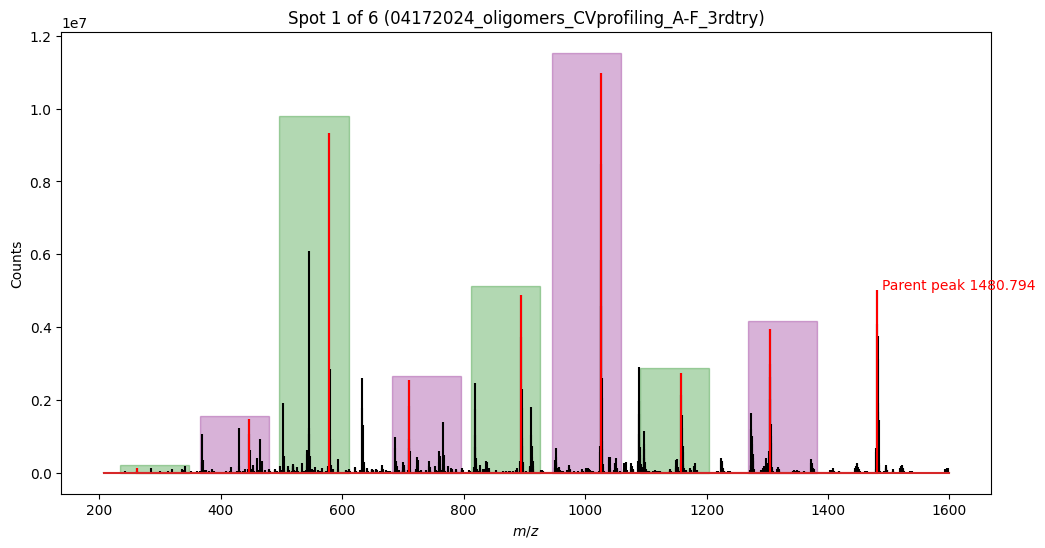

[WARNING] Small parent peaks can cause unusual results with thresholds larger than 0.01.
	MONOMER: 1526.83 - Phe
	MONOMER: 1349.752 - D2Cha
	MONOMER: 1164.612 - Leu
	MONOMER: 1021.517 - D2Cha
	MONOMER: 836.377 - D2Abu
	MONOMER: 719.302 - Phe
	MONOMER: 542.224 - Ala
	MONOMER: 441.175 - D2Phe
	ENDCAP : 262.084 (target=262.084) - Tyr(OMe)


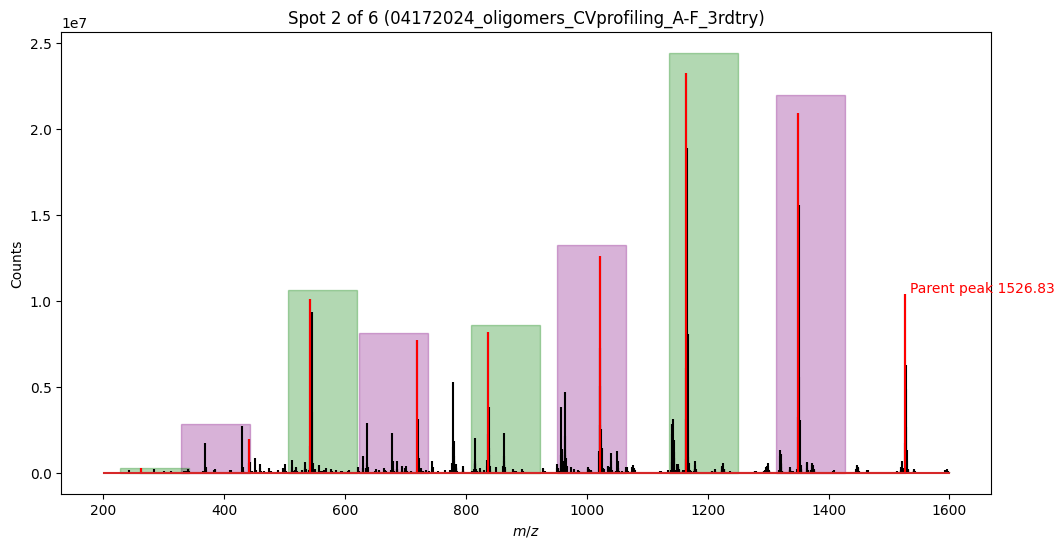

[WARNING] Small parent peaks can cause unusual results with thresholds larger than 0.01.
	MONOMER: 1594.769 - Phe
	MONOMER: 1417.689 - Phe
	MONOMER: 1240.61 - HoPhe
	MONOMER: 1049.515 - D2Cha
	MONOMER: 864.375 - D2Abu
	MONOMER: 747.3 - Phe
	MONOMER: 570.221 - Ser
	MONOMER: 439.163 - Phe
	ENDCAP : 262.084 (target=262.084) - Tyr(OMe)


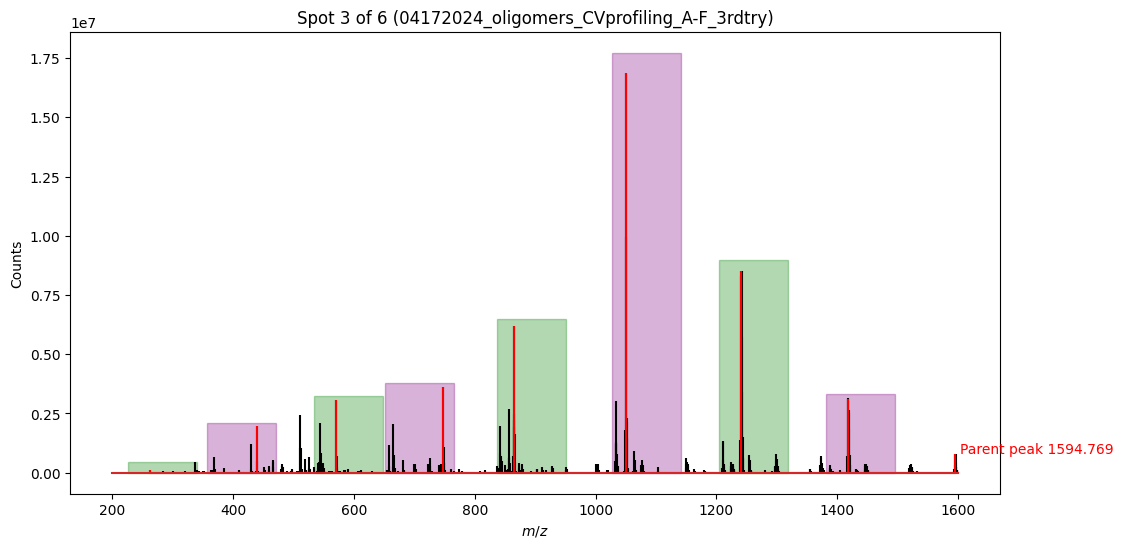

[WARNING] Small parent peaks can cause unusual results with thresholds larger than 0.01.
	MONOMER: 1290.611 - Phe
	MONOMER: 1113.532 - Ala
	MONOMER: 1012.482 - Cha
	MONOMER: 829.356 - D2Ala
	MONOMER: 726.295 - Ala
	MONOMER: 625.248 - Ser
	MONOMER: 494.19 - Ser
	MONOMER: 363.132 - Ala
	ENDCAP : 262.084 (target=262.084) - Tyr(OMe)


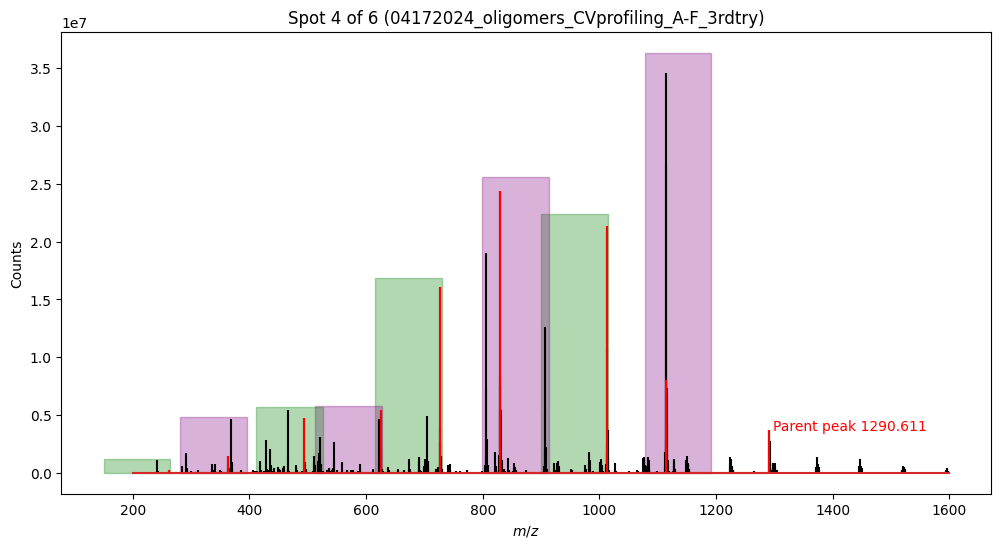

[WARNING] Small parent peaks can cause unusual results with thresholds larger than 0.01.
	MONOMER: 1420.688 - Phe
	MONOMER: 1243.61 - Phe
	MONOMER: 1066.53 - Abu
	MONOMER: 951.466 - Ser
	MONOMER: 820.407 - Gly(allyl)
	MONOMER: 693.344 - D2Abu
	MONOMER: 576.268 - Ser
	MONOMER: 445.21 - Cha
	ENDCAP : 262.084 (target=262.084) - Tyr(OMe)


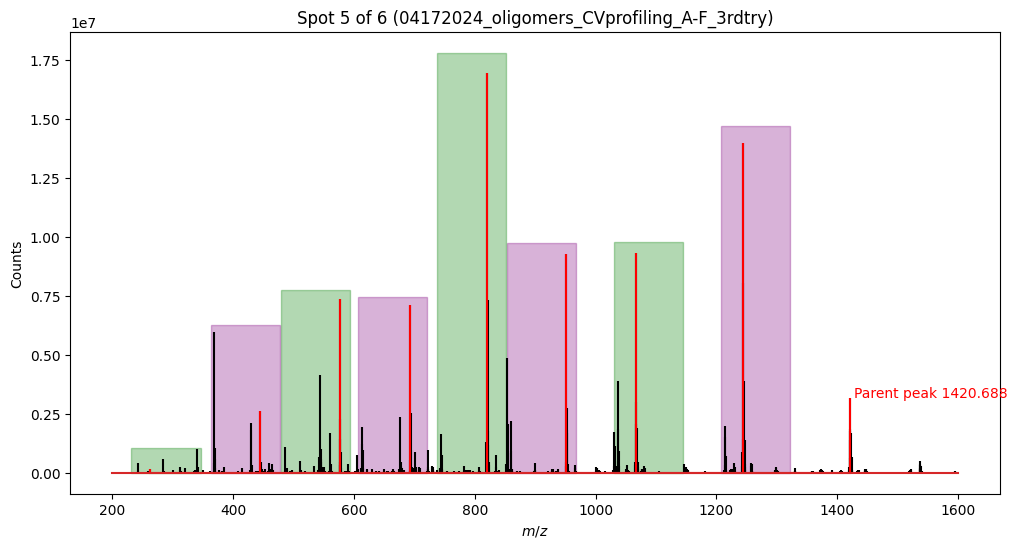

[WARNING] Small parent peaks can cause unusual results with thresholds larger than 0.01.
	MONOMER: 1526.797 - Phe
	MONOMER: 1349.719 - Gly(allyl)
	MONOMER: 1222.655 - D2Cha
	MONOMER: 1037.515 - Leu
	MONOMER: 894.42 - D2Abu
	MONOMER: 777.343 - HoPhe
	MONOMER: 586.25 - D2HoPhe
	MONOMER: 393.142 - Ser
	ENDCAP : 262.084 (target=262.084) - Tyr(OMe)


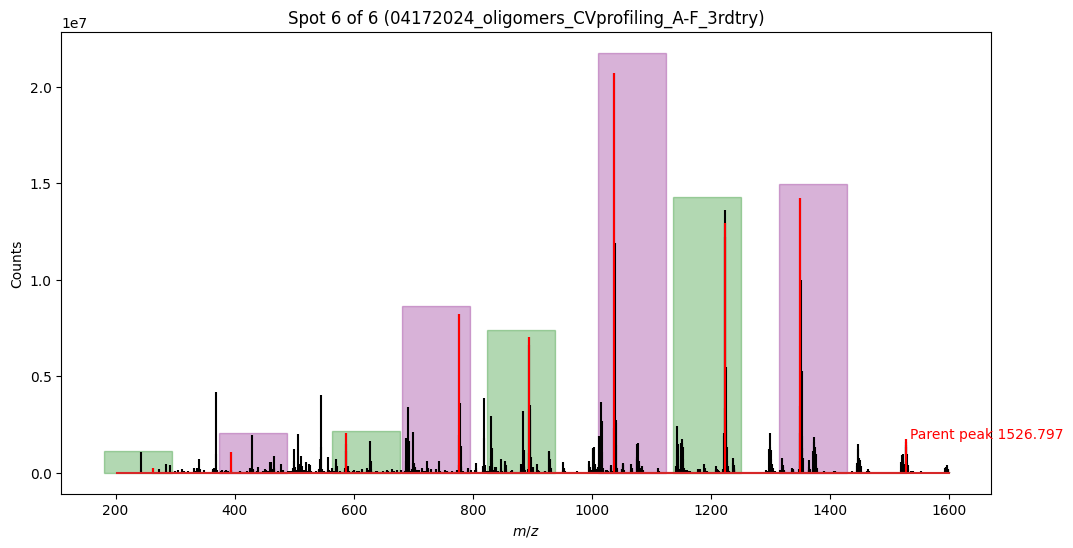

In [4]:
dataframes_for_spots = []
ms_spectra_for_spots = []

# Iterate over every spot (which is the combined intensities over all scans which were done for that spot)
for spot_idx, scan in enumerate(combined_scans):

    ScansTemp = pd.DataFrame(list(scan.items()), columns=['Mass', 'Intensity'])

    # Find the parent oligomer mass
    parent_mass = find_parent_mass(scanData=ScansTemp, 
                                   threshold = parent_peak_threshold, 
                                   debug=debug)
    parent_mass_intensity = float(ScansTemp[ScansTemp["Mass"] == parent_mass]['Intensity'].iloc[0])

    #if i == 1:
    #    exit('DEBUG EXITING')
    if debug:
        print(f'[DEBUG] spot_idx: {spot_idx}\tParent mass in spectrum: {parent_mass}\tIntensity: {parent_mass_intensity}')

    # Find the peaks
    FoundSpectraMassesIntensity, window_bounds = identify_masses_from_sequencing(scan_data=ScansTemp, 
                                                                                 mass_monomer_definitions=monomer_masses,
                                                                                 parent_mass=parent_mass,
                                                                                 intensity_threshold=intensity_threshold,
                                                                                 endcap_mass=endcap_mass, 
                                                                                 debug=debug)

    # Convert the mass:intensity pairs into list of masses
    FoundSpectraMasses = list(FoundSpectraMassesIntensity.keys())
    
    # Get the deltas for these
    deltas = []
    for i, m in enumerate(FoundSpectraMasses):
        if i == len(FoundSpectraMasses) - 1:
            break
        deltas.append(float(m) - FoundSpectraMasses[i + 1])
    
    # Add endcap (last mass found) to the deltas list
    deltas.append(FoundSpectraMasses[-1])
    

    MassMatches = [mass_to_monomer(x, 
                                   mass_monomer_definitions=monomer_masses, 
                                   endcap_tolerance=endcap_tolerance, 
                                   endcap_mass=endcap_mass, 
                                   endcap_name=endcap_name, 
                                   debug=debug) for x in deltas]

    # This is just stored for printing
    results = []

    # Iterate over the masses
    for j, mass_found_in_spectrum in enumerate(FoundSpectraMasses):
        if j == len(MassMatches):
            print(f'[WARNING] There were {j} or more masses identified in spectrum while we have {len(MassMatches)} mass matches')
            break
        if MassMatches[j] == endcap_name:
            print(f'\tENDCAP : {mass_found_in_spectrum} (target={endcap_mass}) - {MassMatches[j]}')
            results.append([j, endcap_mass, endcap_name + '(endcap)'])
        else:
            results.append([j, mass_found_in_spectrum, MassMatches[j]])
            print(f'\tMONOMER: {mass_found_in_spectrum} - {MassMatches[j]}')

    result = pd.DataFrame(results, columns=['Signal No.', 'M/Z', 'Monomer lost']).set_index('Signal No.')

    # Append the result dataframe
    dataframes_for_spots.append(result)

    # Initiate plotting here so we can plot within other functions
    fig, ax = plt.subplots(1,1, figsize = (12,6))

    for i, bound_tuple in enumerate(window_bounds):
        if i % 2 == 0:
            color = 'purple'
        else:
            color = 'green'
        h = ScansTemp[(ScansTemp['Mass'] >= bound_tuple[0]) & (ScansTemp['Mass'] <= bound_tuple[1])].Intensity.max() * 1.05
        rect = plt.Rectangle((bound_tuple[0], 0), width = bound_tuple[1] - bound_tuple[0], height = h, color=color, alpha = 0.3)
        plt.gca().add_patch(rect)

    # Plot the full spectrum
    x, y = zip(*sorted(scan.items()))
    ax.stem(x, y, linefmt='black', markerfmt='')
    ax.set_title(f"Spot {spot_idx + 1} of {len(spots)} ({file.stem})")
    ax.set_ylabel('Counts')
    ax.set_xlabel(r'$m/z$')
    ax.stem(FoundSpectraMassesIntensity.keys(), FoundSpectraMassesIntensity.values(), linefmt='red', markerfmt='') #, width=1.5

    ax.text(parent_mass*1.005, parent_mass_intensity * 1.005, f'Parent peak {parent_mass}', color='red')

    image_path = fig_dir / f'{file.stem}_spotidx_{spot_idx}.png'
    plt.savefig(image_path, format='png', dpi = 600)
    plt.show()
    ms_spectra_for_spots.append(image_path)
